In [6]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('D:/MCA/Breast-cancer Detection/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
    break

In [7]:
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.filters import roberts

from skimage.morphology import disk, binary_closing, remove_small_objects, binary_erosion
from scipy.ndimage import binary_fill_holes

from skimage.transform import resize
from scipy.ndimage import median_filter
from skimage.exposure import equalize_adapthist

def pp(image):
    # Convert the image to grayscale if it's in RGB format
    if image.ndim == 3 and image.shape[-1] == 3:
        image = rgb2gray(image)

    # Apply Gaussian smoothing to reduce noise and enhance edges
    sigma = 1.6
    smoothed_image = gaussian(image, sigma)

    # Apply Sobel edge detection to extract edges
    edge_image = roberts(smoothed_image)

    # Perform morphological operations to close gaps in the edges
    se = disk(4)
    closed_image = binary_closing(edge_image, se)

    # Fill holes in the closed edges
    filled_image = binary_fill_holes(closed_image)

    # Remove small objects and noise
    min_object_area = 600
    cleaned_image = remove_small_objects(filled_image, min_object_area)

    # Multiply the cleaned image with the original image to extract the breast region
    breast_image = (image * cleaned_image).astype(np.uint8)
    breast_image1 = np.subtract(image, breast_image)

    binary_image = image > 165

    # Remove small objects (potential white lines) from the binary image
    cleaned_image = remove_small_objects(binary_image, 100)

    # Identify the largest connected component (assumed to be the background)
    labeled_image = label(cleaned_image)
    properties = regionprops(labeled_image)
    areas = [prop.area for prop in properties]
    background_label = np.argmax(areas) + 1
    background = labeled_image == background_label

    # Remove white lines by subtracting the background from the original image
    lineless_image = np.subtract(breast_image1, background.astype(np.uint8) * 255)

    # Resize the image to the desired size (2000x1000)
    desired_size = (2000, 1000)
    resized_image = resize(lineless_image, desired_size, mode='reflect')

    # Apply median filtering
    filtered_image = median_filter(resized_image, size=(3, 3, 3))

    # Apply CLAHE to enhance the mammogram
    enhanced_image = equalize_adapthist(filtered_image, clip_limit=0.01, nbins=256)

    # Apply morphological erosion to make the tumor part prominent
    se = disk(4)
    eroded_image = binary_erosion(enhanced_image, se)

    # Make the edges of the image black with 25-pixel thickness
    border_thickness = 50
    eroded_image[:border_thickness, :] = 0  # Top border
    eroded_image[-border_thickness:, :] = 0  # Bottom border
    eroded_image[:, :border_thickness] = 0  # Left border
    eroded_image[:, -border_thickness:] = 0  # Right border
    e=eroded_image

    # Return the preprocessed image
    return e

In [8]:
import pandas as pd 
import numpy as np 
import cv2
import PIL
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import glob
import random
import os
from os import listdir
random.seed(100)
np.random.seed(100)

In [9]:
dicom_data = pd.read_csv('D:/MCA/Breast-cancer Detection/input/dataset/csv/dicom_info.csv')

In [10]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [11]:
cropped_images=dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [12]:
image_dir = 'D:/MCA/Breast-cancer Detection/input/dataset/jpeg'

In [13]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     D:/MCA/Breast-cancer Detection/input/dataset/j...
3     D:/MCA/Breast-cancer Detection/input/dataset/j...
6     D:/MCA/Breast-cancer Detection/input/dataset/j...
7     D:/MCA/Breast-cancer Detection/input/dataset/j...
10    D:/MCA/Breast-cancer Detection/input/dataset/j...
Name: image_path, dtype: object

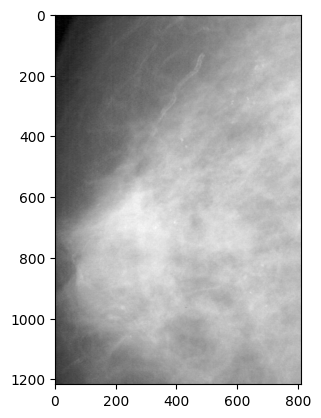

In [14]:
for file  in cropped_images[0:5]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [15]:
full_mammogram_images=dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [16]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images[1]

'D:/MCA/Breast-cancer Detection/input/dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'

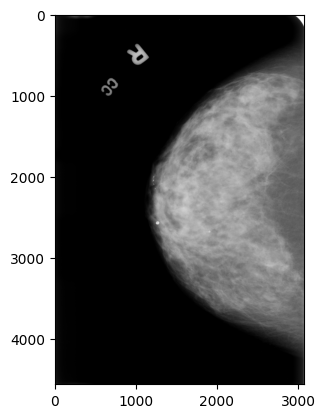

In [17]:
for file  in full_mammogram_images[0:5]:    
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [18]:
ROI_mask_images=dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [19]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     D:/MCA/Breast-cancer Detection/input/dataset/j...
8     D:/MCA/Breast-cancer Detection/input/dataset/j...
9     D:/MCA/Breast-cancer Detection/input/dataset/j...
14    D:/MCA/Breast-cancer Detection/input/dataset/j...
20    D:/MCA/Breast-cancer Detection/input/dataset/j...
Name: image_path, dtype: object

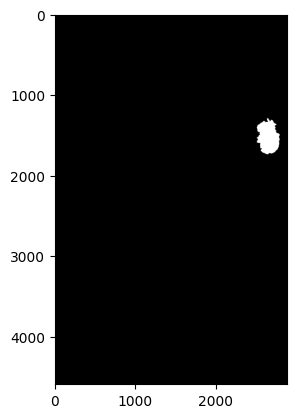

In [15]:
for file  in ROI_mask_images[0:5]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [21]:
data_1=pd.read_csv('D:/MCA/Breast-cancer Detection/input/dataset/csv/calc_case_description_train_set.csv')

In [22]:
data_1.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [23]:
data_1.describe()

,breast density,abnormality id,assessment,subtlety
count,1546.000000,1546.000000,1546.000000,1546.000000
mean,2.663648,1.415265,3.258732,3.411384
std,0.937219,0.903571,1.229231,1.179754
min,1.000000,1.000000,0.000000,1.000000
25%,2.000000,1.000000,2.000000,3.000000
50%,3.000000,1.000000,4.000000,3.000000
75%,3.000000,1.000000,4.000000,4.000000
max,4.000000,7.000000,5.000000,5.000000


In [24]:
data_2=pd.read_csv('D:/MCA/Breast-cancer Detection/input/dataset/csv/mass_case_description_train_set.csv')

In [25]:
data_2.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [26]:
data_2.describe()

,breast_density,abnormality id,assessment,subtlety
count,1318.000000,1318.000000,1318.000000,1318.000000
mean,2.203338,1.116085,3.504552,3.965857
std,0.873774,0.467013,1.414609,1.102032
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


In [27]:
dicom_cleaning_data = dicom_data.copy()
dicom_cleaning_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [28]:
dicom_cleaning_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True) 

In [29]:
dicom_cleaning_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [30]:
dicom_cleaning_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

In [31]:
dicom_cleaning_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

In [32]:
dicom_cleaning_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [33]:
Data_cleaning_1 = data_1.copy()

In [34]:
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})

In [35]:
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})


In [36]:
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})

In [37]:
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})

In [38]:
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})

In [39]:
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})

In [40]:
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')

In [41]:
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')

In [42]:
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')

In [43]:
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')

In [44]:
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')

In [45]:
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')

In [46]:
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [47]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True) 

In [48]:
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)

In [49]:
Data_cleaning_1.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [50]:
Data_cleaning_2 = data_2.copy()

In [51]:
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})

In [52]:
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})

In [53]:
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})

In [54]:
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})

In [55]:
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})

In [56]:
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')

In [57]:
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')

In [58]:
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')

In [59]:
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')

In [60]:
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')

In [61]:
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')

In [62]:
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [63]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True) 

In [64]:
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)

In [65]:
Data_cleaning_2.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [66]:
#------------DATASET 2 ----------------- 

In [77]:
import glob
breast_img = glob.glob('D:/MCA/Breast-cancer Detection/input/archive/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [78]:
for imgname in breast_img[:3]:
    print(imgname)

D:/MCA/Breast-cancer Detection/input/archive/IDC_regular_ps50_idx5\8863\0\8863_idx5_x1001_y1001_class0.png
D:/MCA/Breast-cancer Detection/input/archive/IDC_regular_ps50_idx5\8863\0\8863_idx5_x1001_y1051_class0.png
D:/MCA/Breast-cancer Detection/input/archive/IDC_regular_ps50_idx5\8863\0\8863_idx5_x1001_y1101_class0.png


In [79]:
non_can_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_can_img.append(img)
    
    elif img[-5] == '1' :
        can_img.append(img)

In [80]:
non_can_num = len(non_can_img)  # No cancer
can_num = len(can_img)   # Cancer 
        
total_img_num = non_can_num + can_num
        
print('Number of Images of no cancer: {}' .format(non_can_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(can_num))   # images of cancer 
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 3714
Number of Images of cancer : 752
Total Number of Images : 4466


In [81]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [102618,32719]})

In [82]:
data_insight_1

,state of cancer,Numbers of Patients
0,0,102618
1,1,32719


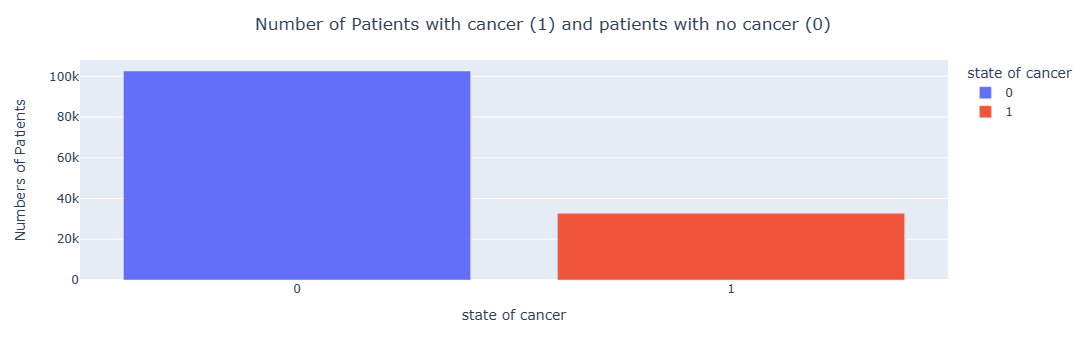

In [83]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

3714


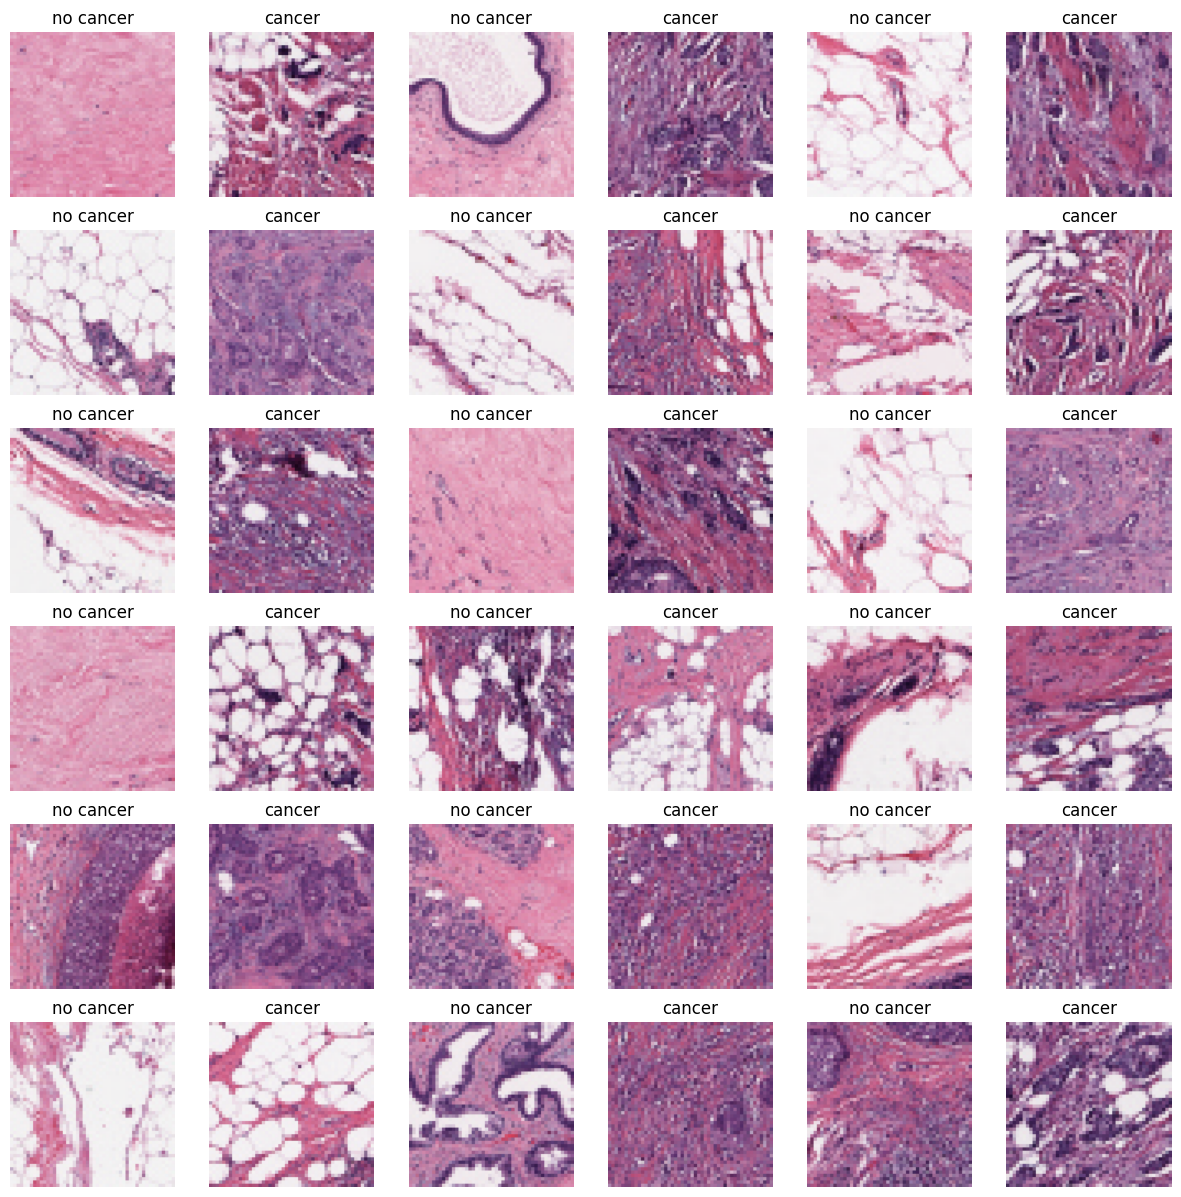

In [84]:
from keras.preprocessing import image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_can_img), 18)
some_can = np.random.randint(0, len(can_img), 18)
print(len(non_can_img))
s = 0
for num in some_non:
    
        img = image.load_img((non_can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_can:
    
        img = image.load_img((can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

In [85]:
from matplotlib.image import imread
import cv2

some_non_img = random.sample(non_can_img, len(non_can_img))
some_can_img = random.sample(can_img, len(can_img))

non_img_arr = []
can_img_arr = []

for img in some_non_img:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in some_can_img:
    
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [86]:
X = []
y = []

for feature, label in non_img_arr:
    X.append(feature)
    y.append(label)

for feature, label in can_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

print('X shape:', X.shape)


X shape: (4466, 50, 50, 3)


In [87]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

rate = 0.5
num = int(X.shape[0] * rate)

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test siikhape : {}' .format(y_test.shape))

X_train shape : (3349, 50, 50, 3)
X_test shape : (1117, 50, 50, 3)
y_train shape : (3349, 2)
y_test shape : (1117, 2)


In [88]:
import tensorflow as tf 
tf.random.set_seed(100)

In [89]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)),
tf.keras.layers.MaxPooling2D(strides = 2),
tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides = 2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'),
tf.keras.layers.MaxPooling2D((3, 3),strides =2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation = 'relu'),
tf.keras.layers.Dense(2, activation = 'softmax')
])

In [90]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 128)         0

In [91]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [92]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 25 , batch_size = 75)

Epoch 1/25
45/45 [==============================] - 22s 429ms/step - loss: 2.8726 - accuracy: 0.7922 - val_loss: 0.2503 - val_accuracy: 0.9024
Epoch 2/25
45/45 [==============================] - 16s 365ms/step - loss: 0.2609 - accuracy: 0.8913 - val_loss: 0.2163 - val_accuracy: 0.9185
Epoch 3/25
45/45 [==============================] - 17s 384ms/step - loss: 0.2525 - accuracy: 0.8958 - val_loss: 0.2109 - val_accuracy: 0.9176
Epoch 4/25
45/45 [==============================] - 18s 390ms/step - loss: 0.2325 - accuracy: 0.9068 - val_loss: 0.2664 - val_accuracy: 0.8881
Epoch 5/25
45/45 [==============================] - 17s 370ms/step - loss: 0.2230 - accuracy: 0.9125 - val_loss: 0.1867 - val_accuracy: 0.9257
Epoch 6/25
45/45 [==============================] - 16s 355ms/step - loss: 0.2052 - accuracy: 0.9221 - val_loss: 0.4225 - val_accuracy: 0.8290
Epoch 7/25
45/45 [==============================] - 17s 376ms/step - loss: 0.2260 - accuracy: 0.9086 - val_loss: 0.1852 - val_accuracy: 0.9212

In [93]:
model.evaluate(X_test,y_test)

35/35 [==============================] - 2s 44ms/step - loss: 0.3274 - accuracy: 0.9141


[0.32742834091186523, 0.9140555262565613]

35/35 [==============================] - 2s 44ms/step


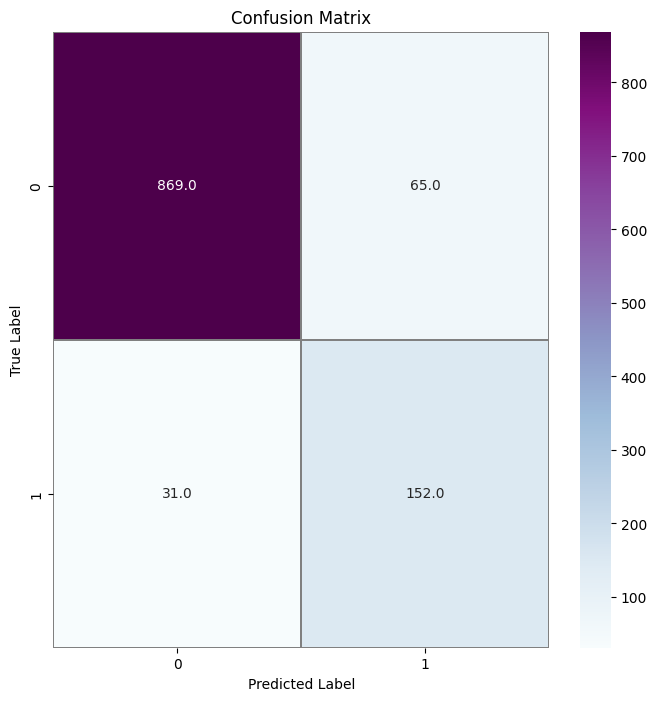

In [94]:
from sklearn.metrics import confusion_matrix,precision_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
a=precision_score(Y_true, Y_pred_classes)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

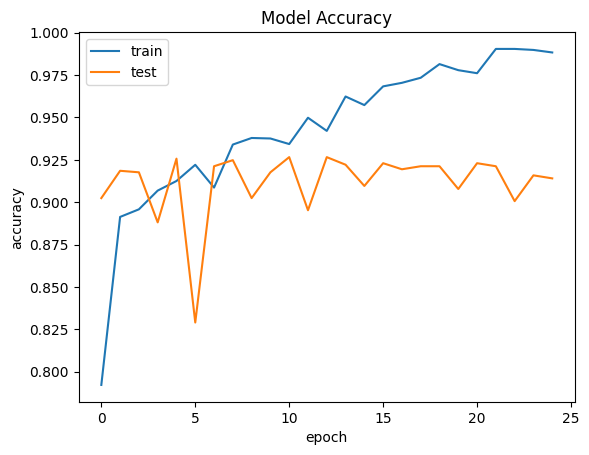

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

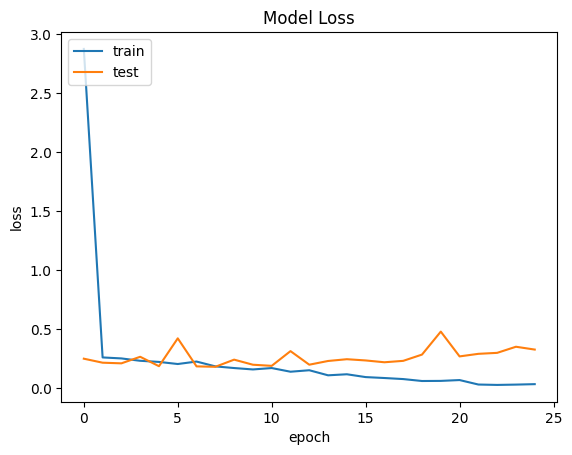

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
prediction = model.predict(X_test)
prediction

35/35 [==============================] - 2s 44ms/step


array([[9.9999952e-01, 5.3365096e-07],
       [1.0000000e+00, 1.2137443e-08],
       [1.0000000e+00, 2.9711268e-08],
       ...,
       [9.9999201e-01, 8.0164427e-06],
       [9.9998534e-01, 1.4692307e-05],
       [2.3446914e-07, 9.9999976e-01]], dtype=float32)

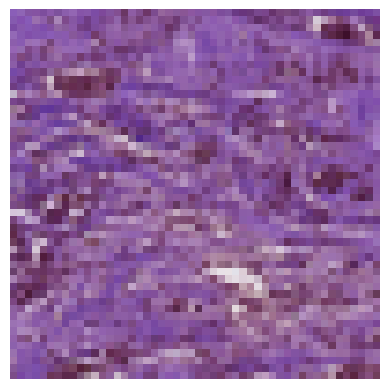

In [98]:
import matplotlib.pyplot as plt

def img_plot(images, index):
    plt.imshow(images[index])
    plt.axis('off')
    plt.show()
index = 90
img_plot(X_test, index)

In [99]:
input = X_test[index:index+1]

In [100]:
pred = model.predict(input)[0].argmax()
label = y_test[index].argmax()

1/1 [==============================] - 0s 58ms/step


In [101]:
print('Predicted Value using  cnn model',pred)
print("True Value",label)

Predicted Value using  cnn model 1
True Value 1
